# Plot a 3D reciprocal space map (3D-RSM)

In reciprocal space ($q$-space) coordinates.

In [1]:
import sxdm
import id01lib

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import ipywidgets as ipw

from matplotlib.colors import LogNorm
from h5glance import H5Glance as h5p

  File "/gpfs/easy/data/id01/inhouse/data_analysis/software/pyenvs/poetry.jupyter-slurm/lib/python3.11/site-packages/silx/third_party/EdfFile.py", line 122, in <module>
    deprecated_warning(


In [2]:
path_data = os.path.abspath("./data/hc2103/id01/20250522/RAW_DATA/")

In [3]:
name_sample = "PTO_STO_SL"
name_dset = "0001"

path_dset = os.path.join(
    path_data,
    name_sample,
    f"{name_sample}_{name_dset}",
    f"{name_sample}_{name_dset}.h5",
)

print(path_dset)

/home/esrf/zatterin/repos/id01-sxdm-utils/doc/source/examples/data/hc2103/id01/20250522/RAW_DATA/PTO_STO_SL/PTO_STO_SL_0001/PTO_STO_SL_0001.h5


In [4]:
with h5py.File(path_dset, "r") as h5f:
    for s in sorted(h5f.keys(), key=lambda a: int(a.split(".")[0])):
        title = h5f[f"{s}/title"][()].decode()
        if "eta" in title:
            print(f"{s:5} {title}")

20.1  ascan eta 15.24 19.24 50 1


In [5]:
scan_no = '20.1'

In [6]:
with h5py.File(path_dset) as h5f:
    frames_sum = h5f[f"{scan_no}/measurement/mpx1x4/"][()].sum(0)

mask = np.zeros_like(frames_sum)
mask[frames_sum > 1e7] = 1
mask[387:403, 217:241] = 1

mpx = id01lib.xrd.detectors.MaxiPix(mask=mask)

In [7]:
nu, delta, phi, eta = [
    id01lib.io.bliss.get_positioner(path_dset, scan_no, x)
    for x in ["nu", "delta", "phi", "eta"]
]

In [8]:
qxg, qyg, qzg, gint = id01lib.xrd.qspace.bliss.get_qspace_gridded(
    path_dset,
    scan_no,
    nbins=(50, 50, 50),
    offsets=dict(phi=phi, nu=0, delta=0),
    detector=mpx,
)

Using cen_pix: row/y=185.604, col/x=172.911
Using det_dist = 0.56685 m
Using energy = 9.99966 keV
NOT correcting the central pixel for mpxy=-7.799999999999997, mpxz=-11.5
------------------
Subtracting 44.997 from phi

Loading frames into memory... Done.

Max. number of bins: (66, 514, 516)
Using binning: (50, 50, 50)


IntSlider(value=27, max=49)

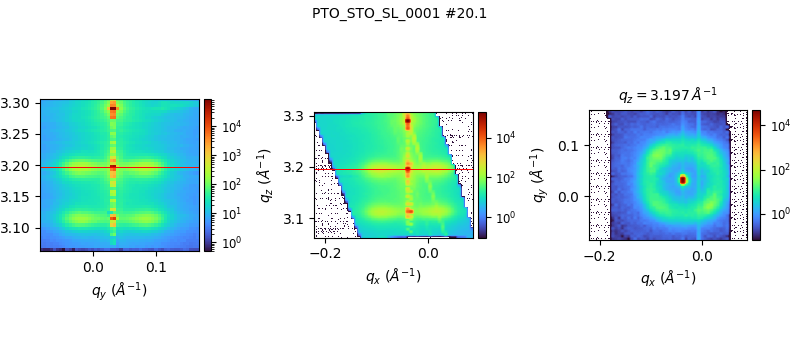

In [9]:
%matplotlib widget
%matplotlib widget

i0 = 27

fig, ax = plt.subplots(
    1, 3, figsize=(8, 3.5), dpi=100, gridspec_kw={"width_ratios": [1, 1, 1]}
)

_ext = sxdm.utils.get_q_extents(qxg, qyg, qzg)
im0 = ax[0].imshow(gint.sum(0).T, extent=_ext[0], norm=LogNorm(), cmap="turbo")

ax[0].set_xlabel(r"$q_y$ ($\AA^{-1}$)")
ax[0].set_ylabel(r"$q_z$ ($\AA^{-1}$)")

im1 = ax[1].imshow(gint.sum(1).T, extent=_ext[1], norm=LogNorm(), cmap="turbo")
ax[1].set_xlabel(r"$q_x$ ($\AA^{-1}$)")
ax[1].set_ylabel(r"$q_z$ ($\AA^{-1}$)")

lines0 = [ax[i].axhline(qzg[i0], c="r", lw=0.7) for i in (0, 1)]

imslice = ax[2].imshow(gint[..., i0].T, extent=_ext[2], norm=LogNorm(), cmap="turbo")

ax[2].set_xlabel(r"$q_x$ ($\AA^{-1}$)")
ax[2].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[2].set_title(f"$q_z = {qzg[i0]:.3f}\,\AA^{{-1}}$", fontsize="medium")

for a in ax:
    im = a.get_images()[0]
    cbar = sxdm.plot.add_colorbar(a, im, size="5%")
    im.origin = "lower"

sample_name = path_dset.split("/")[-2]
title = rf"{sample_name} #{scan_no}"
fig.suptitle(title, fontsize="medium")

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.6)


def sliceit(change):
    i0 = change["new"]
    _0 = [l.set_ydata([qzg[i0]]) for l in lines0]
    imslice.set_data(gint[..., i0].T)

    ax[2].set_title(f"$q_z = {qzg[i0]:.3f}\,\AA^{{-1}}$", fontsize="medium")

    fig.canvas.draw()


slider = ipw.IntSlider(value=i0, min=0, max=gint.shape[2] - 1)
slider.observe(sliceit, names="value")
slider